In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
spark = SparkSession \
    .builder \
    .appName("Learning Spark") \
    .getOrCreate()

In [3]:
%%time
!cat harvester/claims/*CLAIMS*jsonl > harvester/claims/aggregated.jsonl
df = spark.read.json("harvester/claims/aggregated.jsonl")

CPU times: user 2.65 s, sys: 684 ms, total: 3.33 s
Wall time: 1min 36s


In [4]:
df.count()

2683

In [5]:
df = df.where("version = '0.0.2'")
df.sort(F.col("scraped_at").desc()).show()

+---------------+------+-------------+--------------------+--------------------+--------------------+-------+
|_corrupt_record| claim|      crawler|          scraped_at|                 url|                uuid|version|
+---------------+------+-------------+--------------------+--------------------+--------------------+-------+
|           null|147188|ClaimsCrawler|2023-11-20 16:00:...|https://www.occ.c...|dec520f3-8bb3-498...|  0.0.2|
|           null| 95968|ClaimsCrawler|2023-11-20 16:00:...|https://co.comput...|6a4afb48-90c7-493...|  0.0.2|
|           null|127254|ClaimsCrawler|2023-11-20 16:00:...|https://mx.comput...|f40da80c-49b1-47a...|  0.0.2|
|           null|147145|ClaimsCrawler|2023-11-20 12:00:...|https://www.occ.c...|5df4cfc2-0138-4ca...|  0.0.2|
|           null| 95512|ClaimsCrawler|2023-11-20 12:00:...|https://co.comput...|33dc98f3-9fd9-46f...|  0.0.2|
|           null|127024|ClaimsCrawler|2023-11-20 12:00:...|https://mx.comput...|c507bf16-5ee4-43c...|  0.0.2|
|         

<Figure size 1800x600 with 0 Axes>

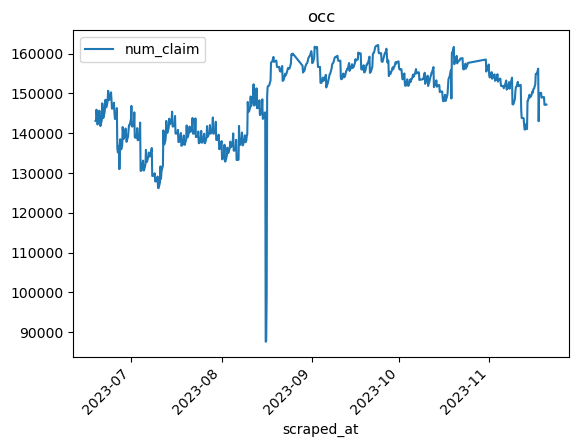

In [6]:
plt.figure(figsize=(18,6))
data = df.where(df.url.startswith("https://www.occ")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).toPandas()
data['scraped_at'] = pd.to_datetime(data['scraped_at'])
data.plot("scraped_at", "num_claim")
plt.title("occ")
_ = plt.xticks(rotation=45)

In [7]:
data

,_corrupt_record,claim,crawler,scraped_at,url,uuid,version,num_claim
0,None,143063,ClaimsCrawler,2023-06-18 16:00:44.927250,https://www.occ.com.mx/empleos/de--/,082e38b5-6379-46b3-ac33-de0a647ffadf,0.0.2,143063
1,None,143082,ClaimsCrawler,2023-06-18 20:00:44.329050,https://www.occ.com.mx/empleos/de--/,2a30674c-ca13-4da2-a3f9-bfb2adef5545,0.0.2,143082
2,None,145898,ClaimsCrawler,2023-06-19 00:00:48.557039,https://www.occ.com.mx/empleos/de--/,5b908799-73e2-4106-9b86-f9b97decd67e,0.0.2,145898
3,None,144438,ClaimsCrawler,2023-06-19 04:00:45.723339,https://www.occ.com.mx/empleos/de--/,7eb416ae-0c05-4a83-8e77-82f65c16657e,0.0.2,144438
4,None,142183,ClaimsCrawler,2023-06-19 08:00:45.075144,https://www.occ.com.mx/empleos/de--/,4646343c-2338-48b3-bf1b-15588d2586ed,0.0.2,142183
...,...,...,...,...,...,...,...,...
861,None,147117,ClaimsCrawler,2023-11-20 00:00:49.934625,https://www.occ.com.mx/empleos/de--/,605f01ac-00f0-456e-b60a-6133dd34fa04,0.0.2,147117
862,None,147127,ClaimsCrawler,2023-11-20 04:00:51.239134,https://www.occ.com.mx/empleos/de--/,2e7b77f2-f96c-4857-b092-188e75c26fd7,0.0.2,147127
863,None,147109,ClaimsCrawler,2023-11-20 08:00:50.393019,https://www.occ.com.mx/empleos/de--/,3986a7c6-eb1b-4444-b14c-30eae48896a8,0.0.2,147109
864,None,147145,ClaimsCrawler,2023-11-20 12:00:51.609147,https://www.occ.com.mx/empleos/de--/,5df4cfc2-0138-4ca2-99e9-0d0223f11f82,0.0.2,147145


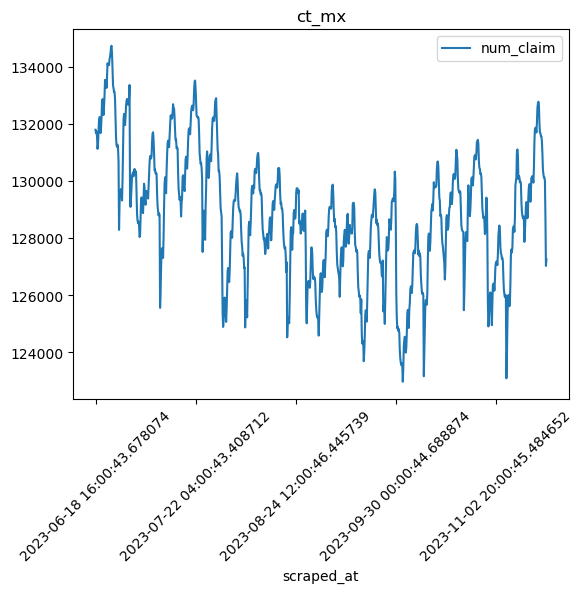

In [8]:
data = df.where(df.url.startswith("https://mx.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).toPandas()
data.plot("scraped_at", "num_claim")
plt.title("ct_mx")
_ = plt.xticks(rotation=45)

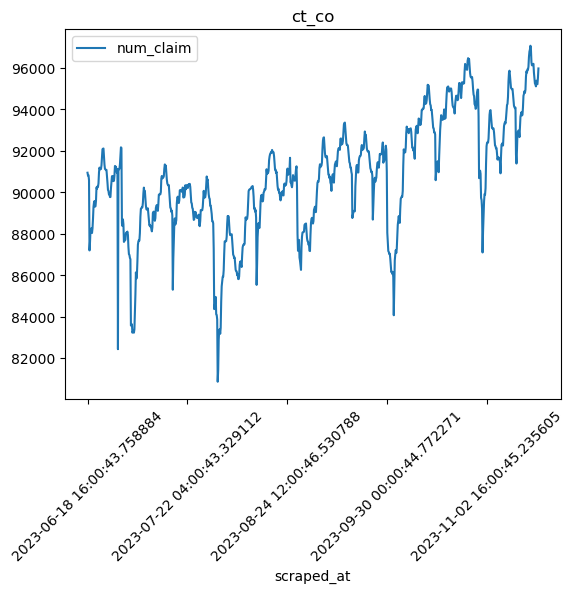

In [9]:
data = df.where(df.url.startswith("https://co.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).toPandas()
data.plot("scraped_at", "num_claim")
plt.title("ct_co")
_ = plt.xticks(rotation=45)

In [10]:
spark.sparkContext.defaultParallelism

4

In [11]:
df.rdd.getNumPartitions()

1

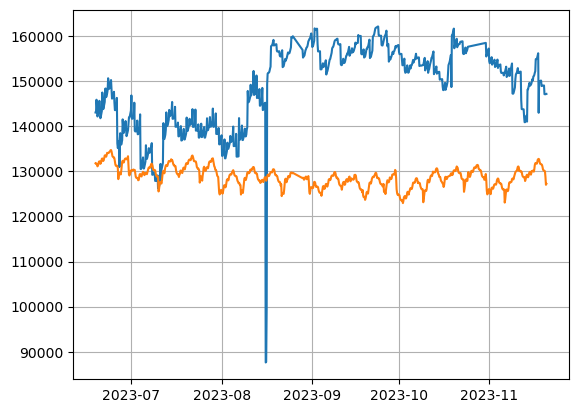

In [12]:
ct = df.where(df.url.startswith("https://mx.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()
occ = df.where(df.url.startswith("https://www.occ")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()

ct['scraped_at'] = pd.to_datetime(ct['scraped_at'])
occ['scraped_at'] = pd.to_datetime(occ['scraped_at'])

plt.plot(occ.set_index('scraped_at'))
plt.plot(ct.set_index('scraped_at'))
plt.grid(which="both")
plt.show()

In [13]:
ct_ts["num_claim"]

NameError: name 'ct_ts' is not defined

In [ ]:
occ_ts = occ.set_index("scraped_at")
ct_ts = ct.set_index("scraped_at")
plt.plot(occ_ts.index, occ_ts["num_claim"])
plt.plot(ct_ts.index, ct_ts["num_claim"])

In [ ]:
plt.plot(occ["num_claim"])
plt.plot(ct["num_claim"])
plt.ylim(bottom=0)
plt.show()